In [51]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from chord_recognition.cache import HDF5Cache
from chord_recognition.cnn import deep_auditory_v2
from chord_recognition.dataset import ChromaDataset, prepare_datasource, balanced_datasource
from chord_recognition.utils import Rescale
from chord_recognition.train import get_weighted_random_sampler, Solver

torch.manual_seed(2020)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
#datasource = prepare_datasource(('queen', 'beatles', 'robbie_williams', 'zweieck'))
datasource = balanced_datasource
model = deep_auditory_v2()

In [53]:
dataset = ChromaDataset(
    datasource, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'),
    transform=Rescale())

In [54]:
# Split dataset into train/val keeping equal proportions of the each class
# Now train and val datasets have equal class probability distributions.
X = [s for s, _ in dataset]
targets = [t for _, t in dataset]
indices = np.arange(len(X))
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X, targets, indices, test_size=0.2, stratify=targets, random_state=11)

In [15]:
# Calculate TRAIN_MEAN, TRAIN_STD
#
# Uncomment, calculate and paste values to utils.py
#
# dataset = ChromaDataset(
#    datasource, window_size=8192, hop_length=4096,
#    cache=HDF5Cache('chroma_cache.hdf5'))
#X_train = np.hstack([sample.squeeze(0) for sample in X_train])
#TRAIN_MEAN = X_train.mean(axis=1)
#TRAIN_MEAN
#TRAIN_STD = X_train.std(axis=1)
#TRAIN_STD

In [47]:
# Balance the classes in each batch which hopefully helps the training.
sampler = get_weighted_random_sampler(targets, y_train)
#del X, targets, X_train, y_train

In [29]:
len(idx_train), len(idx_val)

(206446, 51612)

In [48]:
batch_size = 8

# Split dataset into train/val datasets
# Make sure that train and val datasets have equal class probability distributions.
loader_train = DataLoader(
    dataset=dataset[idx_train],
    batch_size=batch_size,
    sampler=sampler,
    pin_memory=False,
    num_workers=0)
loader_val = DataLoader(
    dataset=dataset[idx_val],
    num_workers=0,
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

In [39]:
learning_rate = 1e-3
epochs=128
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    learning_rate=learning_rate,
    epochs=epochs)
solver.train()

tensor(3.2086, grad_fn=<NllLossBackward>)


AttributeError: 'int' object has no attribute 'float'

[[2 0 0]
 [0 0 1]
 [1 0 2]]


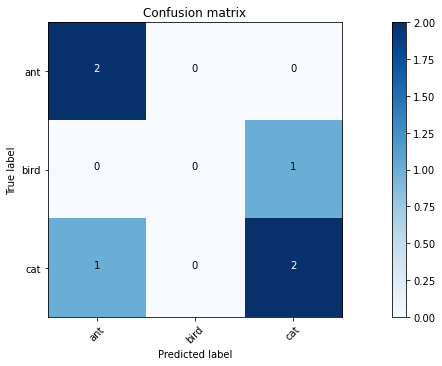

In [56]:
from sklearn.metrics import confusion_matrix

from chord_recognition.utils import one_hot
from chord_recognition.ann_utils import convert_annotation_matrix
from chord_recognition.evaluate import plot_confusion_matrix
from chord_recognition.predict import forward

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = deep_auditory_v2(pretrained=True)
model.eval()

x_val_loader = DataLoader(X_val, batch_size=32)
y_hat_matrix = forward(model, val_loader, device, 25).data.numpy()

y_matrix = one_hot(y_val, 25)
y_true = convert_annotation_matrix(y_matrix)

y_pred = convert_annotation_matrix(y_matrix)
labels = ["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plot_confusion_matrix(cm, labels)

In [ ]:
# Eliminate overfitting:
# - Try CNN -> CTC loss https://www.cs.toronto.edu/~graves/icml_2006.pdf
# - try CNN for extraction a sequence of features and vanilla RNN to propagate information through this sequence.